In [1]:
import cv2
from PIL import Image
import os
import re
import time
import numpy as np
from sklearn import svm
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
from mahotas.features import zernike_moments
from mahotas.features import haralick

In [2]:
def load_from_dir(dir, dir_cat, data):
    for file in os.listdir(dir):
        if not file.endswith(".jpg"):
            continue

        filename = os.path.join(dir, file)
        zoom = int(re.search(r'\d+x', file).group()[:-1])

        data['filename'].append(filename)
        data['category'].append(dir_cat)
        data['zoom'].append(zoom)

In [3]:
def get_hu(X):
    features = []
    for x in X:
        img_hu = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        hu_features = cv2.HuMoments(cv2.moments(img_hu)).flatten()
        features.append(hu_features)

    return features


def get_zernike(X):
    features = []
    radius = 10
    for x in X:
        x = x[:, :, 0]
        #img_zernike = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        img_zernike = x
        zernike_features = zernike_moments(img_zernike, radius).flatten()
        features.append(zernike_features)

    return features    


def get_hu_and_zernike(X):
    features = []
    radius = 10
    for x in X:
        img_hu = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        hu_features = cv2.HuMoments(cv2.moments(img_hu)).flatten()

        img_zernike = x[:, :, 0]
        zernike_features = zernike_moments(img_zernike, radius).flatten()

        img_features = img_features = np.hstack([hu_features, zernike_features])
        features.append(img_features)

    return features

In [4]:
DATA_DIR = 'data/old_data/cut_structures/'

data = {
    'filename': [],
    'category': [],
    'zoom': [],
}

#load_from_dir(DATA_DIR + '0', '0', data) # kreski
load_from_dir(DATA_DIR + 'I', 'I', data) # kreski
load_from_dir(DATA_DIR + 'II', 'II', data) # kleksy
load_from_dir(DATA_DIR + 'III', 'III', data) # robaczki
load_from_dir(DATA_DIR + 'IV', 'IV', data) # mroczki
load_from_dir(DATA_DIR + 'V', 'V', data) # plamy
load_from_dir(DATA_DIR + 'VI', 'VI', data) # kółka

df = pd.DataFrame(data)

In [5]:
df

filename category  zoom
0     data/old_data/cut_structures/I\Kopia 0_origina...        I   500
1     data/old_data/cut_structures/I\Kopia 0_origina...        I   500
2     data/old_data/cut_structures/I\Kopia 0_origina...        I   500
3     data/old_data/cut_structures/I\Kopia 0_origina...        I   500
4     data/old_data/cut_structures/I\Kopia 0_origina...        I   500
...                                                 ...      ...   ...
1553  data/old_data/cut_structures/VI\Kopia 53_1_3_5...       VI   500
1554  data/old_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500
1555  data/old_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500
1556  data/old_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500
1557  data/old_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500

[1558 rows x 3 columns]

In [6]:
X = []
y = []
for _, data in df.iterrows():
    img = cv2.imread(data.filename)
    X.append(img)
    y.append(data.category)
X = np.array(X)
y = np.array(y)

In [7]:
X.shape

(1558, 251, 335, 3)

In [8]:
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

## Hu moments

In [9]:
X_train_features_hu = get_hu(X_train)
X_test_features_hu = get_hu(X_test)

#X_train_features[0].shape

clf_svm_hu = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_hu.fit(X_train_features_hu, y_train)

clf_svm_hu.score(X_test_features_hu, y_test)

0.2980769230769231

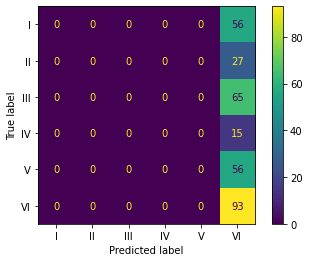

In [10]:
plot_confusion_matrix(clf_svm_hu, X_test_features_hu, y_test)  
plt.show()

## Zernike moments

In [11]:
X_train_features_zernike = get_zernike(X_train)
X_test_features_zernike = get_zernike(X_test)

#X_train_features_zernike[0].shape

clf_svm_zernike = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_zernike.fit(X_train_features_zernike, y_train)

clf_svm_zernike.score(X_test_features_zernike, y_test)

0.6410256410256411

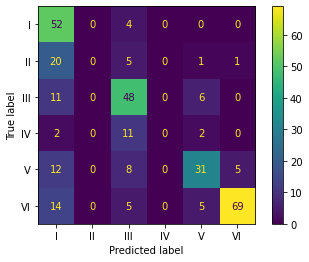

In [12]:
plot_confusion_matrix(clf_svm_zernike, X_test_features_zernike, y_test)  
plt.show()

In [13]:
#y_pred = clf_svmz.predict(X_test_features_zernike)
#confusion_matrix(y_test, y_pred)

## Zernike and Hu moments

In [14]:
X_train_features_hu_and_zernike = get_hu_and_zernike(X_train)
X_test_features_hu_and_zernike = get_hu_and_zernike(X_test)

clf_svm_hu_and_zernike = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_svm_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.6378205128205128

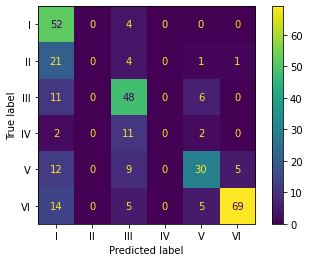

In [15]:
plot_confusion_matrix(clf_svm_hu_and_zernike, X_test_features_hu_and_zernike, y_test)  
plt.show()

## Pixels

In [16]:
nsamples, nx, ny, nz = X_train.shape
Xd2_train = X_train.reshape((nsamples,nx*ny*nz))

nsamplest, nxt, nyt, nzt = X_test.shape
Xd2_test = X_test.reshape((nsamplest,nxt*nyt*nzt))

In [17]:
clf_svm = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm.fit(Xd2_train, y_train)

clf_svm.score(Xd2_test, y_test)

0.6282051282051282

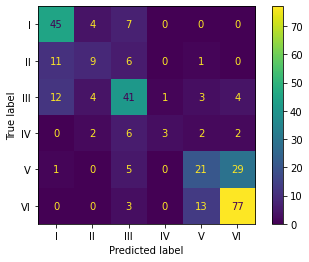

In [18]:
plot_confusion_matrix(clf_svm, Xd2_test, y_test)  
plt.show()